<table class="table table-bordered">
    <tr>
        <th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Problem 2 - Sentiment Analysis Model  (Group)</h2><h3>AY2025 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
from tensorflow import keras
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, GRU
from keras import regularizers
from tensorflow.keras.optimizers import RMSprop

import pickle

## Step 1 – Data Loading and Processing (Group)

### 1.1 Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Deep Learning/teams_reviews1.csv')
texts = df['content'].astype(str).tolist()

df = df[['score', 'content']]
df.head()

,score,content
0,1,fees are absolutely HORRENDOUS. Disgusting. Gr...
1,1,"App is useless now, can't purchase from app an..."
2,3,There needs to be a feature that buyers can bl...
3,4,Good app. Communication to sellers is odd thou...
4,4,"it great, im selling two items. No one still b..."


### 1.2 Data Processing


In [ ]:
# Check the distribution of scores
print("Original score distribution:")
print(df['score'].value_counts())

# Find the minimum number of reviews among all score values
min_count = df['score'].value_counts().min()

# Sample 'min_count' reviews from each score
balanced_df = df.groupby('score').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

# Check the new distribution
print("\nBalanced score distribution:")
print(balanced_df['score'].value_counts())

# Save the balanced dataset
output_path = '/content/drive/MyDrive/Deep Learning/balanced_teams_reviews.csv'
balanced_df.to_csv(output_path, index=False)

Original score distribution:
score
5    393171
4     44849
1     43878
3     10806
2      7496
Name: count, dtype: int64

Balanced score distribution:
score
1    7496
2    7496
3    7496
4    7496
5    7496
Name: count, dtype: int64


/tmp/ipython-input-4-2209498552.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('score').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [3]:
# Load the balanced dataset
df = pd.read_csv('/content/drive/My Drive/Deep Learning/balanced_teams_reviews.csv')
texts = df['content'].astype(str).tolist()

df = df[['score', 'content']]
df.head()

,score,content
0,1,Make watchlistS viewable in app. Only the defa...
1,1,OMG the new layout is awful on a tablet! Who t...
2,1,It wont work it keeps sayin it needs to update...
3,1,When it comes to ebay selling the people that ...
4,1,it's nice to sell to other people on a large p...


In [4]:
# Clean the data
def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

texts = [clean_text(t) for t in texts]

In [5]:
# Convert the content and scores into numeric tensors
maxlen = 40  # We will cut reviews after 40 words
max_words = 10000  # We will only consider the top 10,000 words (vocabulary) in the dataset (dictionary)

tokenizer = Tokenizer(num_words=max_words) # num_words: the maximum number of words to keep, based on word frequency.

tokenizer.fit_on_texts(texts)

# Save tokenizer
with open("/content/drive/MyDrive/Deep Learning/tokenizer_weijun.pickle", "wb") as f:
    pickle.dump(tokenizer, f)

sequences = tokenizer.texts_to_sequences(texts)
print(sequences[0])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = df['score'].astype(int).tolist()
labels = np.asarray(labels)

# Convert labels to categorical (for 5-class classification)
labels = labels - 1  # Now labels are 0 to 4 as Keras expect class labels to start from 0
labels = to_categorical(labels, num_classes=5)

X = data
y = labels

[114, 3092, 3779, 20, 7, 66, 2, 778, 899, 9, 3779, 20, 7, 82, 3, 1712, 14, 733, 33, 241, 4135, 832, 3, 149, 15, 125, 89, 12, 14, 104, 8633, 6, 4, 168, 478, 574, 58, 60, 214, 162, 59, 534, 122, 150]
Found 19774 unique tokens.


### 1.3 Data Sampling

In [6]:
# Split the X & y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

### LSTM Base Model

In [ ]:
# Build the Base Model
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(max_words, 128))
model.add(LSTM(32))
model.add(Dense(5, activation='softmax'))
model.summary()

# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 40, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300,773 (4.96 MB)

 Trainable params: 1,300,773 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - acc: 0.3651 - loss: 1.3924 - val_acc: 0.4726 - val_loss: 1.1955
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - acc: 0.4930 - loss: 1.1406 - val_acc: 0.4806 - val_loss: 1.1665
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - acc: 0.5303 - loss: 1.0893 - val_acc: 0.4877 - val_loss: 1.1730
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - acc: 0.5569 - loss: 1.0469 - val_acc: 0.4786 - val_loss: 1.1842
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.5832 - loss: 1.0199 - val_acc: 0.4882 - val_loss: 1.2005
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - acc: 0.6019 - loss: 0.9695 - val_acc: 0.4731 - val_loss: 1.2187
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.6161 - loss: 0.9360 - val_acc: 0.4782 - val_loss: 1.2328
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - acc: 0.6398 - loss: 0.9017 - val_acc: 0.4717 - val_loss: 1.2741
Epoch 9/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step -

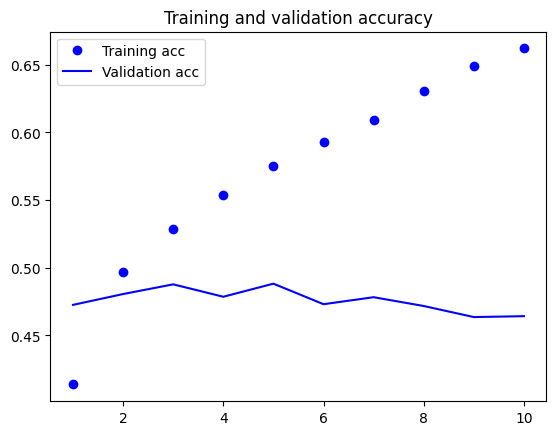

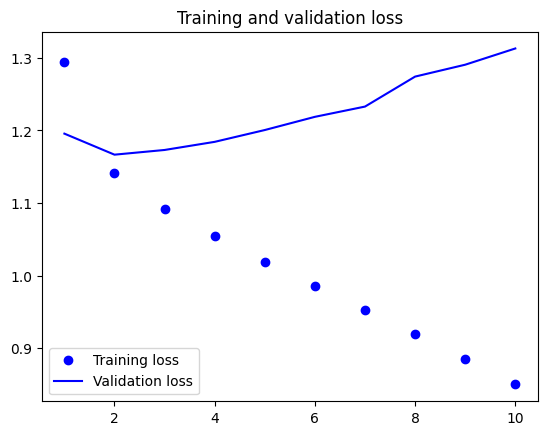

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### LSTM Regularised Model

In [ ]:
# Regularise the model to reduce overfitting
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(max_words, 128))
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001))) # Add dropout, recurrent_droput and l2 regularisation
model.add(Dense(5, activation='softmax'))
model.summary()

# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 40, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300,773 (4.96 MB)

 Trainable params: 1,300,773 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 107s 137ms/step - acc: 0.3426 - loss: 1.4873 - val_acc: 0.4586 - val_loss: 1.2346
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 103s 137ms/step - acc: 0.4658 - loss: 1.2316 - val_acc: 0.4731 - val_loss: 1.1943
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 136ms/step - acc: 0.4890 - loss: 1.1827 - val_acc: 0.4746 - val_loss: 1.1959
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 136ms/step - acc: 0.4972 - loss: 1.1620 - val_acc: 0.4836 - val_loss: 1.1816
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 135ms/step - acc: 0.5225 - loss: 1.1303 - val_acc: 0.4904 - val_loss: 1.1770
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 135ms/step - acc: 0.5242 - loss: 1.1176 - val_acc: 0.4902 - val_loss: 1.1774
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 146s 140ms/step - acc: 0.5312 - loss: 1.1066 - val_acc: 0.4861 - val_loss: 1.1808
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 141ms/step - acc: 0.5385 - loss: 1.0910 - val_acc: 0.4897 - val_loss: 1.1784
Epoch 9/10
750/750 ━━━━━

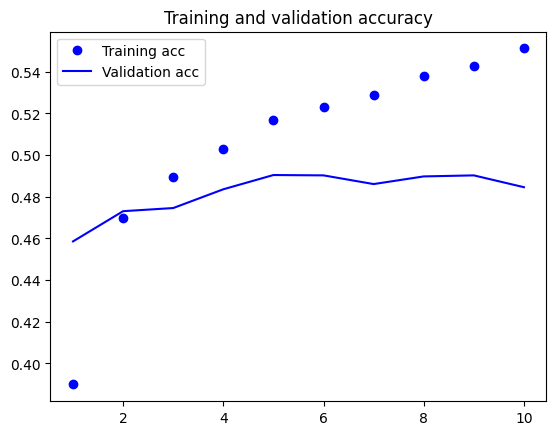

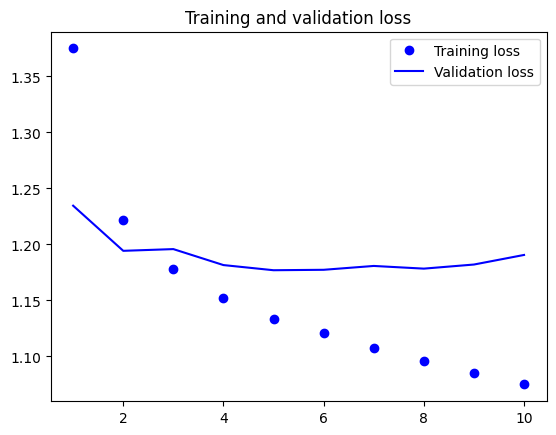

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


### LSTM Model with GloVe Embedding

In [ ]:
# Path to the GloVe file in Drive
glove_path = '/content/drive/My Drive/Deep Learning/glove.6B.100d.txt'

embeddings_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 100
# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400001 word vectors.


In [ ]:
# Build the Model with GloVe embedding (frozen layers)
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=False))
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.summary()

# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,189 (3.88 MB)

 Trainable params: 17,189 (67.14 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 122s 126ms/step - acc: 0.3066 - loss: 1.5762 - val_acc: 0.3837 - val_loss: 1.3710
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 93s 124ms/step - acc: 0.3866 - loss: 1.3875 - val_acc: 0.4222 - val_loss: 1.3138
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 97s 130ms/step - acc: 0.4165 - loss: 1.3306 - val_acc: 0.4062 - val_loss: 1.3407
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 128ms/step - acc: 0.4249 - loss: 1.3196 - val_acc: 0.4352 - val_loss: 1.2756
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 93s 124ms/step - acc: 0.4358 - loss: 1.2999 - val_acc: 0.4347 - val_loss: 1.2764
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 93s 123ms/step - acc: 0.4359 - loss: 1.2941 - val_acc: 0.4391 - val_loss: 1.2838
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - acc: 0.4342 - loss: 1.3037 - val_acc: 0.4444 - val_loss: 1.2583
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 92s 123ms/step - acc: 0.4404 - loss: 1.2826 - val_acc: 0.4549 - val_loss: 1.2479
Epoch 9/10
750/750 ━━━━━━━━━━

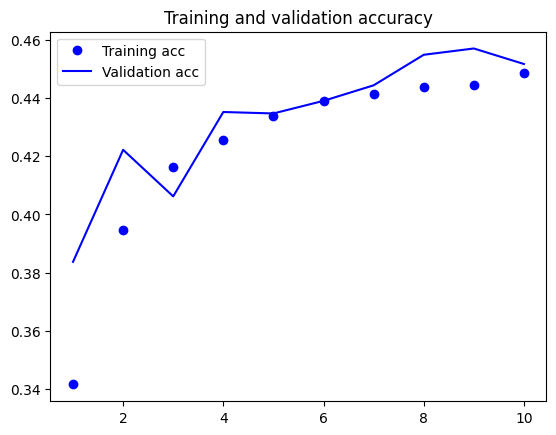

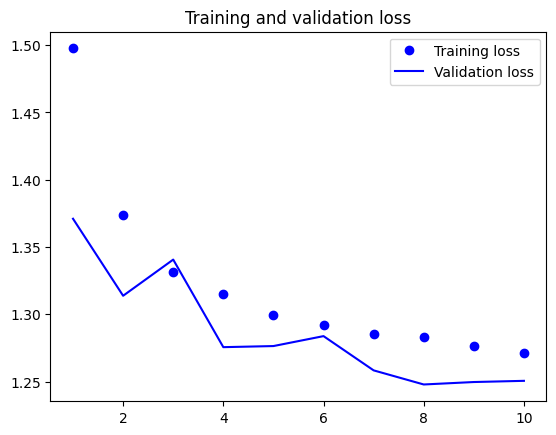

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Model performance worsened hence try unfreezing GloVe embedding in next model

### LSTM Model with unfrozen GloVe embedding

In [ ]:
# Build the Model with GloVe embedding unfrozen
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.summary()



# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,189 (3.88 MB)

 Trainable params: 1,017,189 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 107s 139ms/step - acc: 0.3117 - loss: 1.5573 - val_acc: 0.4182 - val_loss: 1.3135
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 108s 145ms/step - acc: 0.4240 - loss: 1.3159 - val_acc: 0.4587 - val_loss: 1.2417
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 136s 137ms/step - acc: 0.4640 - loss: 1.2422 - val_acc: 0.4867 - val_loss: 1.2045
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - acc: 0.4788 - loss: 1.2001 - val_acc: 0.4857 - val_loss: 1.1963
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 145ms/step - acc: 0.4896 - loss: 1.1918 - val_acc: 0.4944 - val_loss: 1.1834
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 145ms/step - acc: 0.4900 - loss: 1.1821 - val_acc: 0.4989 - val_loss: 1.1786
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 144ms/step - acc: 0.5046 - loss: 1.1560 - val_acc: 0.4949 - val_loss: 1.1812
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 144ms/step - acc: 0.5032 - loss: 1.1450 - val_acc: 0.5008 - val_loss: 1.1715
Epoch 9/10
750/750 ━━━━━

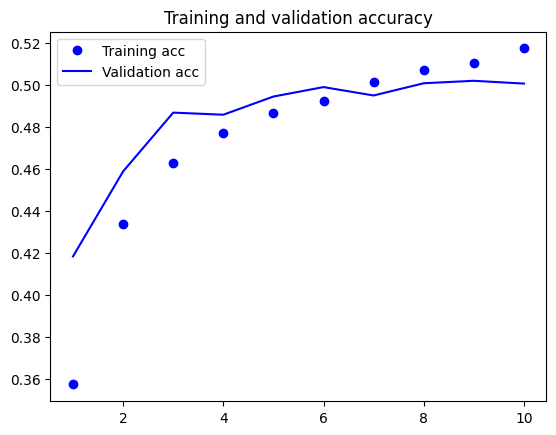

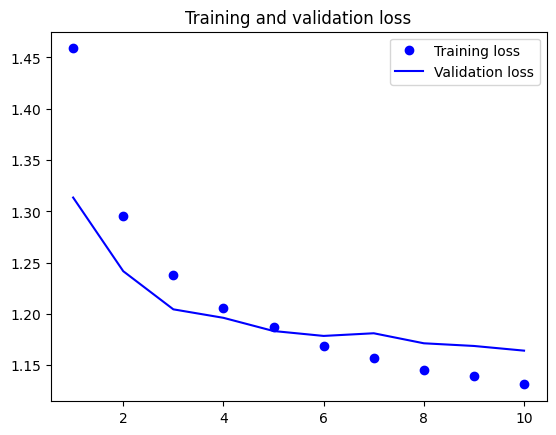

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Unfrozen GloVe embedding performs much better and helped in reducing overfitting

### Scaled-up LSTM Model

In [ ]:
# Scale up the model to overfit model
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(Conv1D(32, 7, activation='relu')) # Added Conv1D layer with 32 units and maxpooling1d layer
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.summary()


# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 34, 32)         │        22,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 17, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,030,917 (3.93 MB)

 Trainable params: 1,030,917 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 67ms/step - acc: 0.3392 - loss: 1.4686 - val_acc: 0.4487 - val_loss: 1.2424
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - acc: 0.4448 - loss: 1.2434 - val_acc: 0.4639 - val_loss: 1.2186
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - acc: 0.4749 - loss: 1.1911 - val_acc: 0.4829 - val_loss: 1.1861
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - acc: 0.4909 - loss: 1.1593 - val_acc: 0.4842 - val_loss: 1.1834
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 66ms/step - acc: 0.5046 - loss: 1.1350 - val_acc: 0.4889 - val_loss: 1.1726
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - acc: 0.5095 - loss: 1.1230 - val_acc: 0.4839 - val_loss: 1.1833
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - acc: 0.5331 - loss: 1.0887 - val_acc: 0.4981 - val_loss: 1.1638
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - acc: 0.5364 - loss: 1.0777 - val_acc: 0.4996 - val_loss: 1.1702
Epoch 9/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 

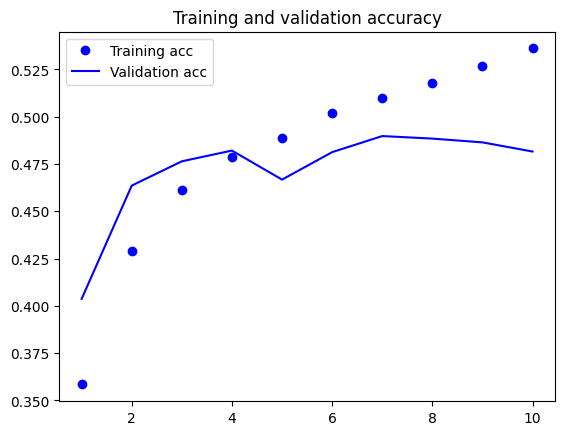

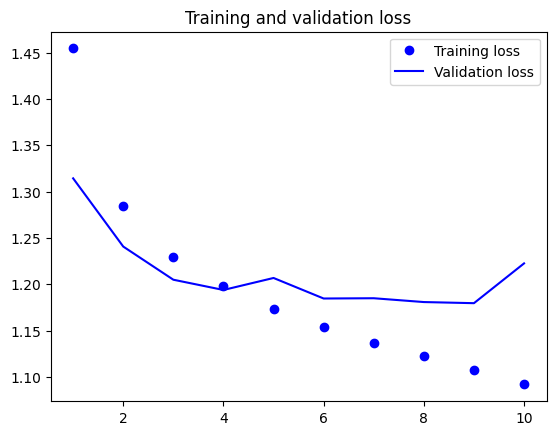

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Tuned and regularised LSTM Model #1

In [ ]:
# Tune Model Hyperparameters and Regularise Model to reduce overfitting
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(Conv1D(32, 3, activation='relu')) # decreased kernel size
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3)) # Add dropout layer
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.summary()


# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 38, 32)         │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,018,117 (3.88 MB)

 Trainable params: 1,018,117 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - acc: 0.3201 - loss: 1.4829 - val_acc: 0.4285 - val_loss: 1.2547
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 70ms/step - acc: 0.4237 - loss: 1.2713 - val_acc: 0.4711 - val_loss: 1.2023
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 70ms/step - acc: 0.4540 - loss: 1.2285 - val_acc: 0.4764 - val_loss: 1.1899
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - acc: 0.4770 - loss: 1.1861 - val_acc: 0.4719 - val_loss: 1.1940
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - acc: 0.4903 - loss: 1.1646 - val_acc: 0.4881 - val_loss: 1.1743
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - acc: 0.5031 - loss: 1.1375 - val_acc: 0.4757 - val_loss: 1.2003
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 73ms/step - acc: 0.5006 - loss: 1.1349 - val_acc: 0.4924 - val_loss: 1.1606
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step - acc: 0.5120 - loss: 1.1178 - val_acc: 0.4907 - val_loss: 1.1694
Epoch 9/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 

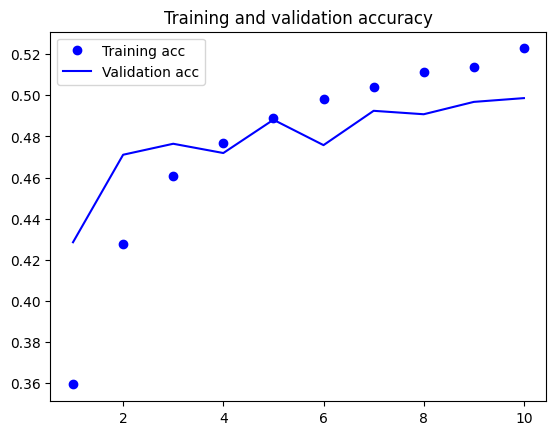

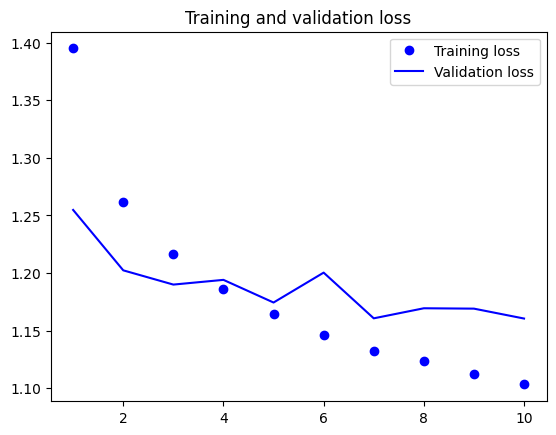

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Tuned and regularised LSTM Model #2

In [ ]:
# Tune Model Hyperparameters and Regularise Model to reduce overfitting
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(Dropout(0.3)) # Add dropout after embedding
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.summary()


# Train the Model
model.compile(optimizer=RMSprop(learning_rate=2e-4), # decreased learning rate to reduce fluctuations
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=30, # Increase epoch to 30 as learning rate is reduced
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 38, 32)         │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,018,117 (3.88 MB)

 Trainable params: 1,018,117 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - acc: 0.2752 - loss: 1.6144 - val_acc: 0.3332 - val_loss: 1.4818
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - acc: 0.3316 - loss: 1.4938 - val_acc: 0.3617 - val_loss: 1.3868
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 77ms/step - acc: 0.3594 - loss: 1.4054 - val_acc: 0.4007 - val_loss: 1.3258
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - acc: 0.3867 - loss: 1.3576 - val_acc: 0.4084 - val_loss: 1.3002
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - acc: 0.3928 - loss: 1.3339 - val_acc: 0.4391 - val_loss: 1.2707
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - acc: 0.4143 - loss: 1.3018 - val_acc: 0.4399 - val_loss: 1.2594
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 80ms/step - acc: 0.4183 - loss: 1.2913 - val_acc: 0.4461 - val_loss: 1.2431
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 78s 75ms/step - acc: 0.4302 - loss: 1.2712 - val_acc: 0.4519 - val_loss: 1.2349
Epoch 9/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 

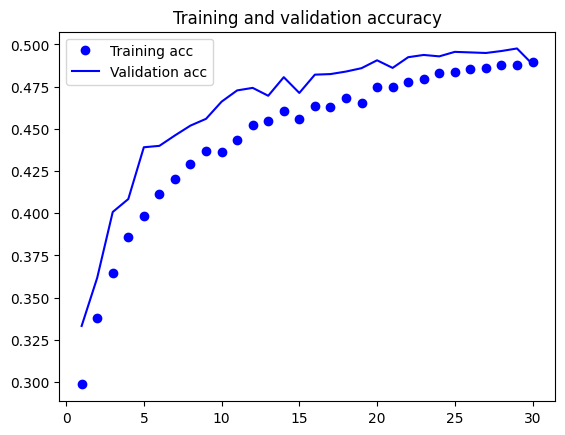

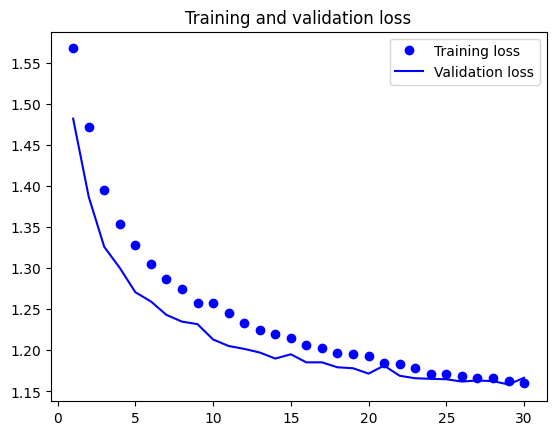

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Since the tuned scaled up model achieved a lower val by 30 epochs and validation loss is plateauing towards the end, model is reaching learning capacity, indicating that additional conv1d layer did not contribute to generalisation.
# Moreover, the model without the Conv1D layer shows less fluctuations in the curves despite having a higher learning rate.
# Hence, I revert back to the original model before scaling up as it avoids unnecessary complexity while achieving higher and more consistent validation performance,

### Regularised non scaled-up LSTM Model #1

In [ ]:
# Regularise and tune hyperparameters of the model (the model prior to scaling up) to reduce the slight overfit
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(Dropout(0.3)) # Add dropout after embedding
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.summary()

# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=20,  # Train for more epochs
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,189 (3.88 MB)

 Trainable params: 1,017,189 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 113s 145ms/step - acc: 0.3125 - loss: 1.5801 - val_acc: 0.3964 - val_loss: 1.3395
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 145ms/step - acc: 0.4012 - loss: 1.3516 - val_acc: 0.4481 - val_loss: 1.2585
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 147s 151ms/step - acc: 0.4377 - loss: 1.2779 - val_acc: 0.4722 - val_loss: 1.2230
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 139s 147ms/step - acc: 0.4607 - loss: 1.2386 - val_acc: 0.4771 - val_loss: 1.2026
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 145s 151ms/step - acc: 0.4691 - loss: 1.2110 - val_acc: 0.4782 - val_loss: 1.1939
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 152ms/step - acc: 0.4819 - loss: 1.1961 - val_acc: 0.4867 - val_loss: 1.1839
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 144s 154ms/step - acc: 0.4846 - loss: 1.1829 - val_acc: 0.4847 - val_loss: 1.1893
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 137s 148ms/step - acc: 0.4989 - loss: 1.1650 - val_acc: 0.4986 - val_loss: 1.1737
Epoch 9/20
750/750 ━━━━━

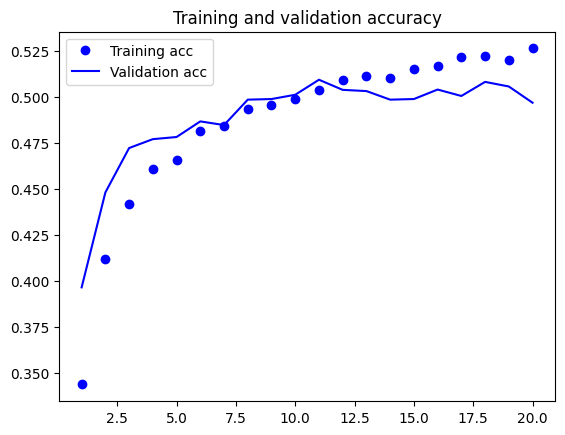

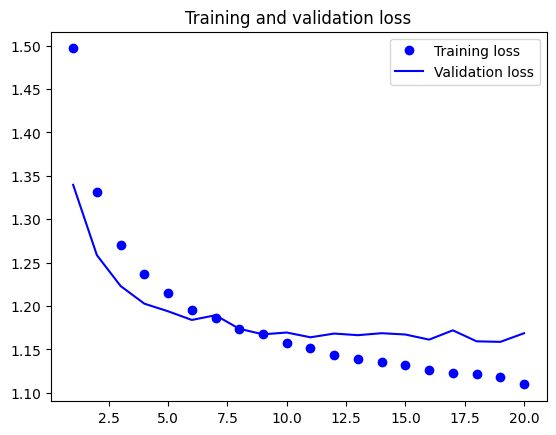

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Regularised non scaled-up LSTM Model #2 (Final LSTM Model)

In [ ]:
# Regularise and tune hyperparameters
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(Dropout(0.4)) # Increase dropout rate
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.summary()

# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=13, #reduce epochs to avoid overfitting
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,189 (3.88 MB)

 Trainable params: 1,017,189 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 107s 138ms/step - acc: 0.3114 - loss: 1.5655 - val_acc: 0.4087 - val_loss: 1.3273
Epoch 2/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 103s 137ms/step - acc: 0.3961 - loss: 1.3567 - val_acc: 0.4422 - val_loss: 1.2717
Epoch 3/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 137ms/step - acc: 0.4349 - loss: 1.2882 - val_acc: 0.4777 - val_loss: 1.2232
Epoch 4/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 137ms/step - acc: 0.4548 - loss: 1.2486 - val_acc: 0.4822 - val_loss: 1.2081
Epoch 5/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 137ms/step - acc: 0.4673 - loss: 1.2250 - val_acc: 0.4886 - val_loss: 1.1975
Epoch 6/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 103s 137ms/step - acc: 0.4692 - loss: 1.2159 - val_acc: 0.4876 - val_loss: 1.1864
Epoch 7/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 137ms/step - acc: 0.4842 - loss: 1.1947 - val_acc: 0.4926 - val_loss: 1.1796
Epoch 8/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 103s 137ms/step - acc: 0.4796 - loss: 1.1952 - val_acc: 0.4956 - val_loss: 1.1808
Epoch 9/13
750/750 ━━━━━

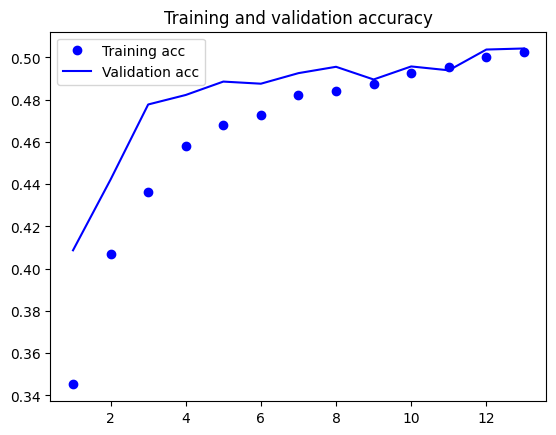

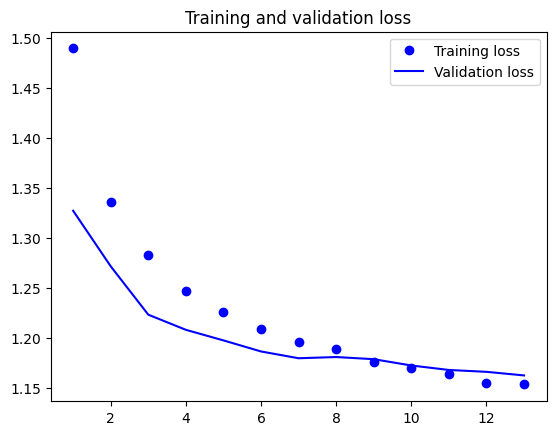

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Training and validation accuracy and loss began to plateau, indicating that the model had reached its maximum learning capacity without overfitting.
# Hence I selected this model as my final model for LSTM

In [ ]:
# Save the Model
model.save('/content/drive/MyDrive/Deep Learning/LSTM_model.keras')

### Model to test if it is over-regularised

In [ ]:
# Additional step to check if model is over-regularised
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(Dropout(0.4))
model.add(LSTM(32, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001))) # Remove regular dropout
model.add(Dense(5, activation='softmax'))
model.summary()

# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=13, #reduce epochs to avoid overfitting
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,189 (3.88 MB)

 Trainable params: 1,017,189 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - acc: 0.3387 - loss: 1.5298 - val_acc: 0.4476 - val_loss: 1.2832
Epoch 2/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 139s 129ms/step - acc: 0.4363 - loss: 1.2989 - val_acc: 0.4619 - val_loss: 1.2379
Epoch 3/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 138s 124ms/step - acc: 0.4635 - loss: 1.2339 - val_acc: 0.4777 - val_loss: 1.2036
Epoch 4/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - acc: 0.4806 - loss: 1.2027 - val_acc: 0.4796 - val_loss: 1.1943
Epoch 5/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 125ms/step - acc: 0.4925 - loss: 1.1732 - val_acc: 0.4829 - val_loss: 1.1887
Epoch 6/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - acc: 0.5024 - loss: 1.1550 - val_acc: 0.4894 - val_loss: 1.1851
Epoch 7/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 123ms/step - acc: 0.5093 - loss: 1.1369 - val_acc: 0.4886 - val_loss: 1.1718
Epoch 8/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 95s 127ms/step - acc: 0.5068 - loss: 1.1417 - val_acc: 0.4916 - val_loss: 1.1827
Epoch 9/13
750/750 ━━━━━━

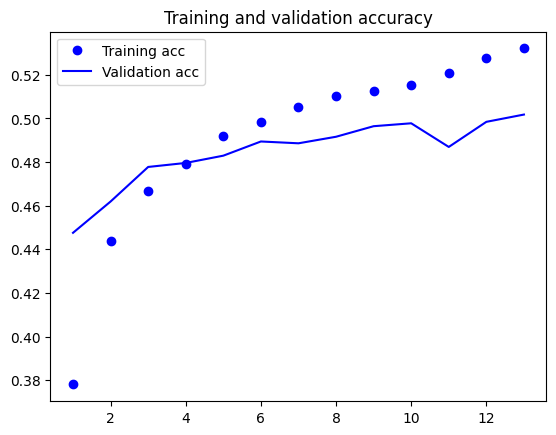

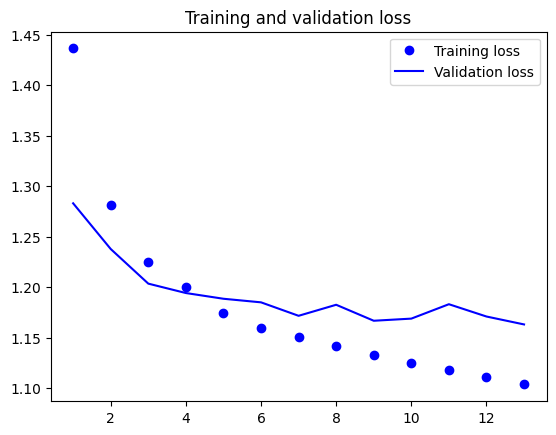

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Since model started overfitting, regularisation was necessary to reduce this overfitting and confirms and model was not over-regularised

### Final LSTM Model

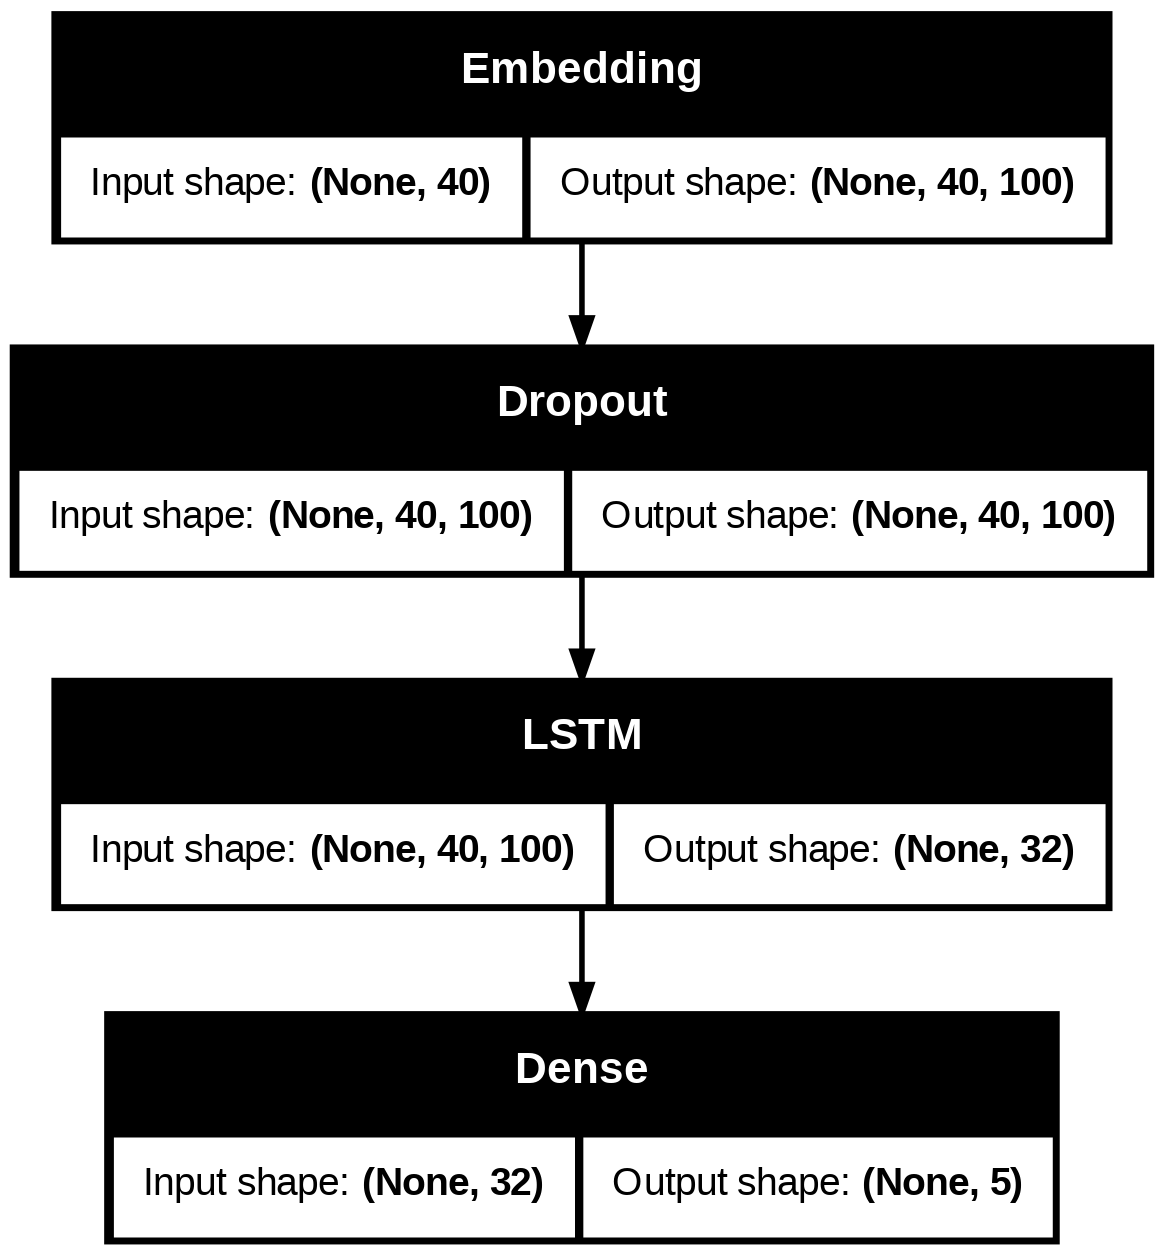

In [ ]:
# Load model
LSTM_model = keras.models.load_model('/content/drive/My Drive/Deep Learning/LSTM_model.keras')
from tensorflow.keras.utils import plot_model
plot_model(LSTM_model, show_shapes = True, to_file='LSTM_model.png')

### Base GRU Model

In [ ]:
# Build the base Model
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(max_words, 128))
model.add(GRU(32))
model.add(Dense(5, activation='softmax'))
model.summary()

# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 40, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,295,717 (4.94 MB)

 Trainable params: 1,295,717 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - acc: 0.3624 - loss: 1.3932 - val_acc: 0.4544 - val_loss: 1.2226
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.4936 - loss: 1.1445 - val_acc: 0.4872 - val_loss: 1.1620
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.5185 - loss: 1.0912 - val_acc: 0.4822 - val_loss: 1.1731
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.5586 - loss: 1.0462 - val_acc: 0.4847 - val_loss: 1.1752
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - acc: 0.5815 - loss: 1.0044 - val_acc: 0.4829 - val_loss: 1.1922
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.5987 - loss: 0.9735 - val_acc: 0.4787 - val_loss: 1.2217
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.6180 - loss: 0.9394 - val_acc: 0.4711 - val_loss: 1.2345
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.6333 - loss: 0.9038 - val_acc: 0.4746 - val_loss: 1.2624
Epoch 9/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - a

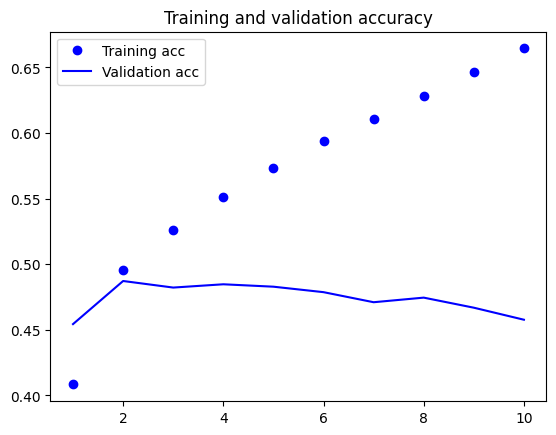

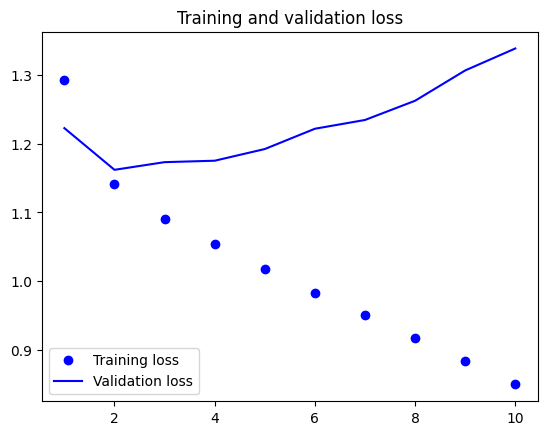

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Regularised GRU Model

In [ ]:
# Build the Regularised model Model
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(max_words, 128))
model.add(GRU(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001))) # Add dropout, recurrent_droput and l2 regularisation
model.add(Dense(5, activation='softmax'))
model.summary()

# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 40, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,295,717 (4.94 MB)

 Trainable params: 1,295,717 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 100s 128ms/step - acc: 0.3458 - loss: 1.5013 - val_acc: 0.4444 - val_loss: 1.2584
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 140s 125ms/step - acc: 0.4585 - loss: 1.2427 - val_acc: 0.4686 - val_loss: 1.2102
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 96s 127ms/step - acc: 0.4925 - loss: 1.1794 - val_acc: 0.4792 - val_loss: 1.1862
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 127ms/step - acc: 0.5047 - loss: 1.1522 - val_acc: 0.4839 - val_loss: 1.1801
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 96s 129ms/step - acc: 0.5117 - loss: 1.1330 - val_acc: 0.4786 - val_loss: 1.1861
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 128ms/step - acc: 0.5232 - loss: 1.1215 - val_acc: 0.4809 - val_loss: 1.1820
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 96s 128ms/step - acc: 0.5335 - loss: 1.1099 - val_acc: 0.4789 - val_loss: 1.1868
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 129ms/step - acc: 0.5405 - loss: 1.0876 - val_acc: 0.4769 - val_loss: 1.1840
Epoch 9/10
750/750 ━━━━━━━━

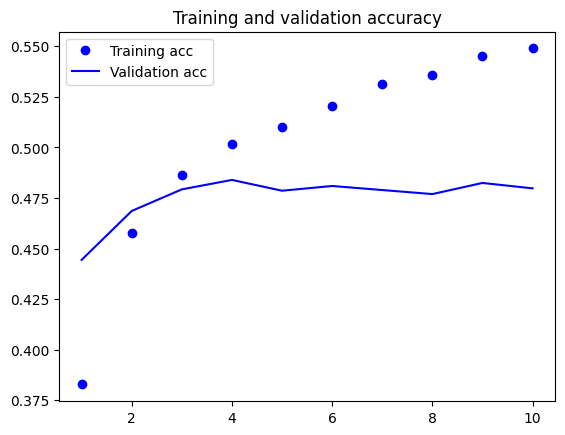

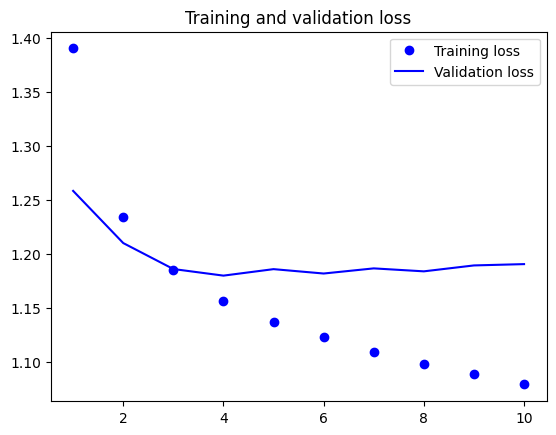

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### GRU Model with unfrozen GloVe embedding

In [ ]:
# Since fine-tuning GloVe embeddings improves performance, use unfrozen GloVe embedding on GRU Model

In [ ]:
# Build the Model with GloVe embedding unfrozen
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(GRU(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.summary()



# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,029 (3.86 MB)

 Trainable params: 1,013,029 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 104s 134ms/step - acc: 0.3066 - loss: 1.5550 - val_acc: 0.4382 - val_loss: 1.2832
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 94s 126ms/step - acc: 0.4223 - loss: 1.3032 - val_acc: 0.4652 - val_loss: 1.2418
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 127ms/step - acc: 0.4641 - loss: 1.2344 - val_acc: 0.4804 - val_loss: 1.2053
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 126ms/step - acc: 0.4719 - loss: 1.2020 - val_acc: 0.4941 - val_loss: 1.1876
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 145s 131ms/step - acc: 0.4860 - loss: 1.1822 - val_acc: 0.4902 - val_loss: 1.1812
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 98s 130ms/step - acc: 0.5014 - loss: 1.1620 - val_acc: 0.4984 - val_loss: 1.1743
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 97s 129ms/step - acc: 0.4980 - loss: 1.1666 - val_acc: 0.4937 - val_loss: 1.1775
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 130ms/step - acc: 0.5070 - loss: 1.1464 - val_acc: 0.5001 - val_loss: 1.1682
Epoch 9/10
750/750 ━━━━━━━━

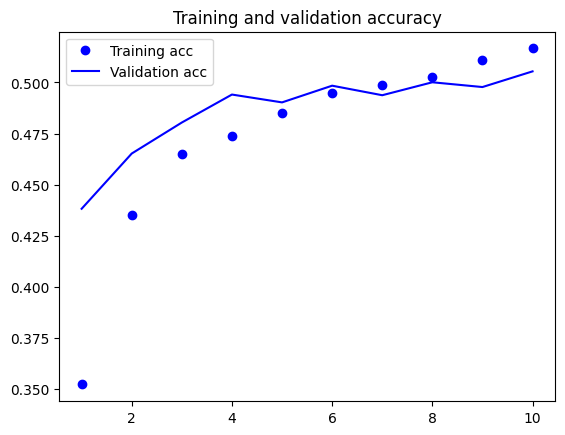

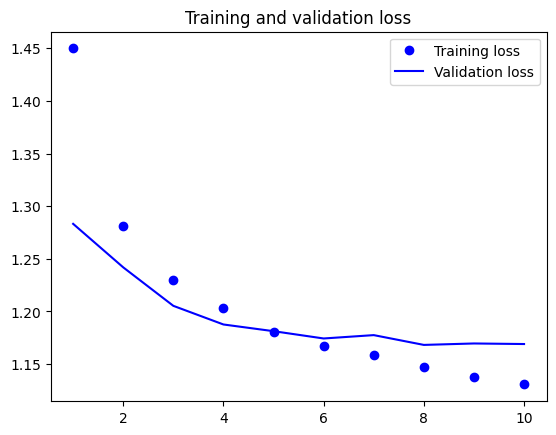

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Scaled-up and regularised GRU Model

In [ ]:
# Reused the tuned, scaled-up architecture from the LSTM model for the GRU because LSTM and GRU are structurally similar, and to see if the
# same setup would perform better with GRU, without tuning everything from scratch
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(Dropout(0.3))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(GRU(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.summary()


# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 38, 32)         │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,016,133 (3.88 MB)

 Trainable params: 1,016,133 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 55s 69ms/step - acc: 0.2896 - loss: 1.5534 - val_acc: 0.4035 - val_loss: 1.2904
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - acc: 0.3853 - loss: 1.3216 - val_acc: 0.4369 - val_loss: 1.2357
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - acc: 0.4296 - loss: 1.2566 - val_acc: 0.4554 - val_loss: 1.2087
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 68ms/step - acc: 0.4474 - loss: 1.2246 - val_acc: 0.4642 - val_loss: 1.1923
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 69ms/step - acc: 0.4503 - loss: 1.2109 - val_acc: 0.4697 - val_loss: 1.1836
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - acc: 0.4650 - loss: 1.1935 - val_acc: 0.4842 - val_loss: 1.1721
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - acc: 0.4703 - loss: 1.1813 - val_acc: 0.4816 - val_loss: 1.1684
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 67ms/step - acc: 0.4892 - loss: 1.1527 - val_acc: 0.4917 - val_loss: 1.1593
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

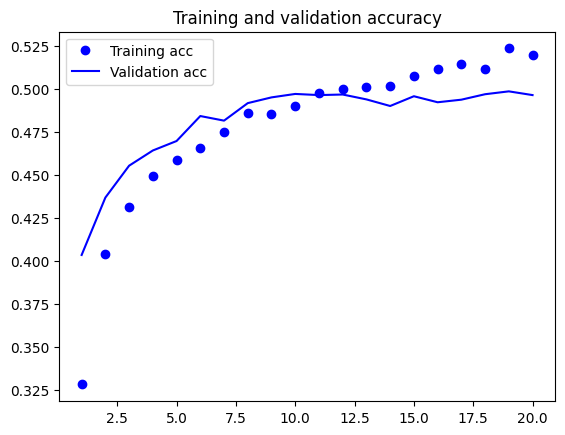

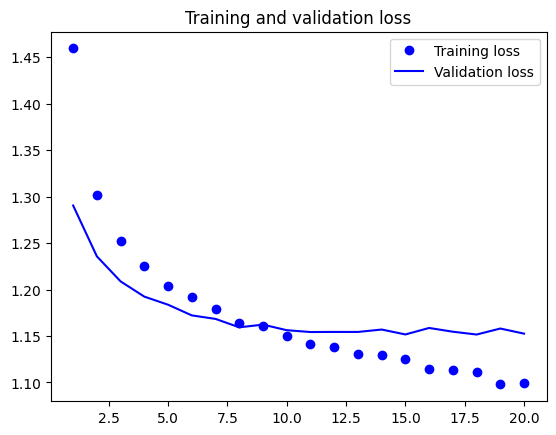

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Further Scale-up GRU Model

In [ ]:
# Scale up Model even more to intentionally overfit model
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(Dropout(0.3))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(GRU(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001))) #Increase GRU units to 64
model.add(GRU(32)) # Added additional GRU layer
model.add(Dense(5, activation='softmax'))
model.summary()


# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 38, 32)         │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 19, 64)         │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,038,021 (3.96 MB)

 Trainable params: 1,038,021 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - acc: 0.3185 - loss: 1.5020 - val_acc: 0.3994 - val_loss: 1.2953
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step - acc: 0.4027 - loss: 1.3065 - val_acc: 0.4466 - val_loss: 1.2280
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 71ms/step - acc: 0.4290 - loss: 1.2483 - val_acc: 0.4379 - val_loss: 1.2290
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step - acc: 0.4428 - loss: 1.2320 - val_acc: 0.4719 - val_loss: 1.1930
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 71ms/step - acc: 0.4612 - loss: 1.2000 - val_acc: 0.4817 - val_loss: 1.1805
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 69ms/step - acc: 0.4689 - loss: 1.1908 - val_acc: 0.4886 - val_loss: 1.1704
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - acc: 0.4700 - loss: 1.1818 - val_acc: 0.4841 - val_loss: 1.1631
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 70ms/step - acc: 0.4780 - loss: 1.1679 - val_acc: 0.4877 - val_loss: 1.1578
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

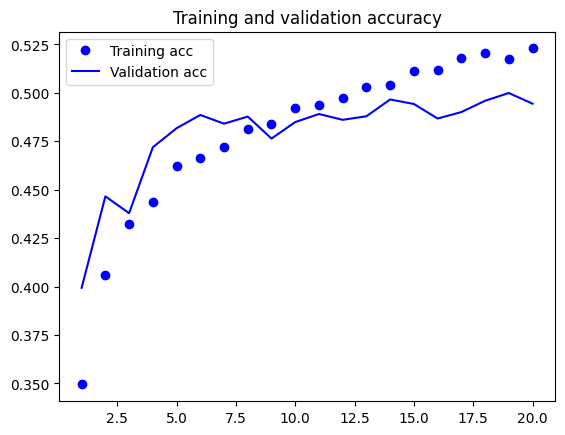

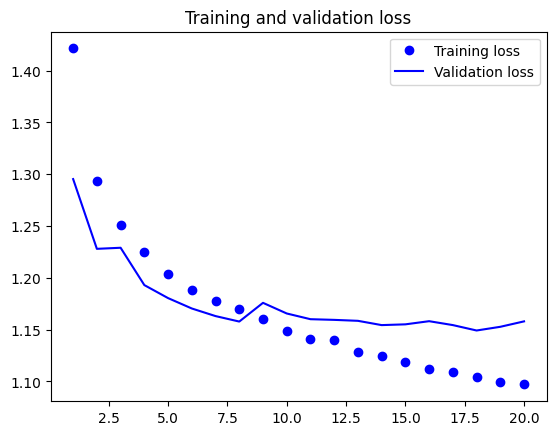

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Further regularised scaled-up GRU Model

In [ ]:
# Further Regularise Model to reduce overfitting
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(Dropout(0.3))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(GRU(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(GRU(32, dropout=0.3, recurrent_dropout=0.2))  # add regular dropout and recurrent dropout to 2nd GRU layer
model.add(Dense(5, activation='softmax'))
model.summary()


# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 38, 32)         │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 19, 64)         │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,038,021 (3.96 MB)

 Trainable params: 1,038,021 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 100s 126ms/step - acc: 0.3145 - loss: 1.5100 - val_acc: 0.4005 - val_loss: 1.2903
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 140s 124ms/step - acc: 0.3917 - loss: 1.3142 - val_acc: 0.4432 - val_loss: 1.2275
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 125ms/step - acc: 0.4351 - loss: 1.2533 - val_acc: 0.4497 - val_loss: 1.2174
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 137s 119ms/step - acc: 0.4374 - loss: 1.2333 - val_acc: 0.4647 - val_loss: 1.2006
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 121ms/step - acc: 0.4454 - loss: 1.2120 - val_acc: 0.4752 - val_loss: 1.1862
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 122ms/step - acc: 0.4622 - loss: 1.1980 - val_acc: 0.4712 - val_loss: 1.1871
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 94s 126ms/step - acc: 0.4648 - loss: 1.1919 - val_acc: 0.4882 - val_loss: 1.1688
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 97s 129ms/step - acc: 0.4759 - loss: 1.1763 - val_acc: 0.4739 - val_loss: 1.1839
Epoch 9/20
750/750 ━━━━━━━

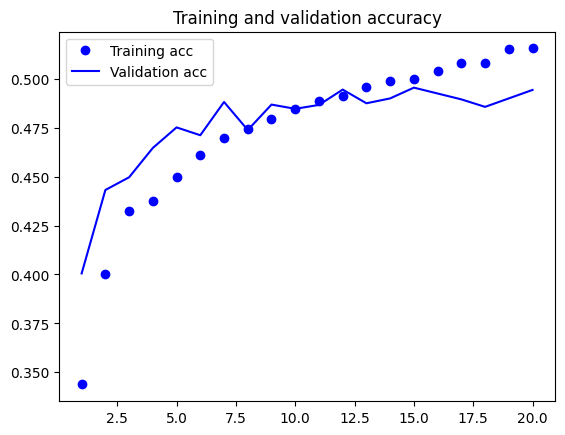

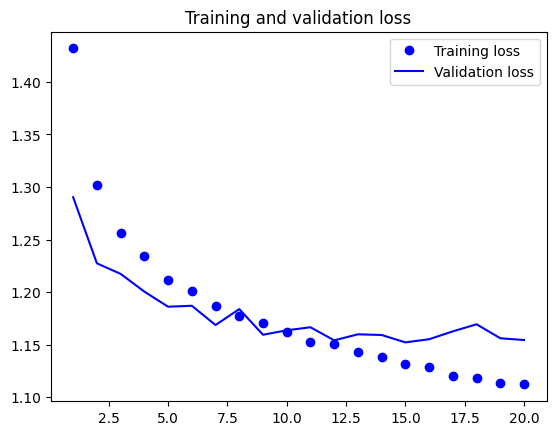

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# After attempting to further scale up and tune model, model performance does not improve
# Similar to LSTM model, I used and improved on the non scaled-up model to avoid unnecesssary complexity and reduce risk of overfitting

### Regularised non scaled-up GRU Model (Final GRU model)

In [ ]:
# Regularise and tune hyperparameters
model = Sequential()
model.add(keras.Input(shape=(maxlen,)))
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
model.add(Dropout(0.3)) # Add dropout after embedding
model.add(GRU(32, dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.summary()

# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=13, # reduce epoch to avoid overfitting
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 40, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 32)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,029 (3.86 MB)

 Trainable params: 1,013,029 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 105s 135ms/step - acc: 0.2912 - loss: 1.6079 - val_acc: 0.4274 - val_loss: 1.3003
Epoch 2/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 147s 141ms/step - acc: 0.4091 - loss: 1.3351 - val_acc: 0.4544 - val_loss: 1.2480
Epoch 3/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 146s 147ms/step - acc: 0.4395 - loss: 1.2724 - val_acc: 0.4691 - val_loss: 1.2215
Epoch 4/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 136s 139ms/step - acc: 0.4547 - loss: 1.2455 - val_acc: 0.4799 - val_loss: 1.2042
Epoch 5/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 140s 137ms/step - acc: 0.4683 - loss: 1.2185 - val_acc: 0.4879 - val_loss: 1.1936
Epoch 6/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 137ms/step - acc: 0.4724 - loss: 1.2003 - val_acc: 0.4846 - val_loss: 1.1859
Epoch 7/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 137ms/step - acc: 0.4783 - loss: 1.1839 - val_acc: 0.4946 - val_loss: 1.1768
Epoch 8/13
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 138ms/step - acc: 0.4944 - loss: 1.1732 - val_acc: 0.4941 - val_loss: 1.1706
Epoch 9/13
750/750 ━━━━━

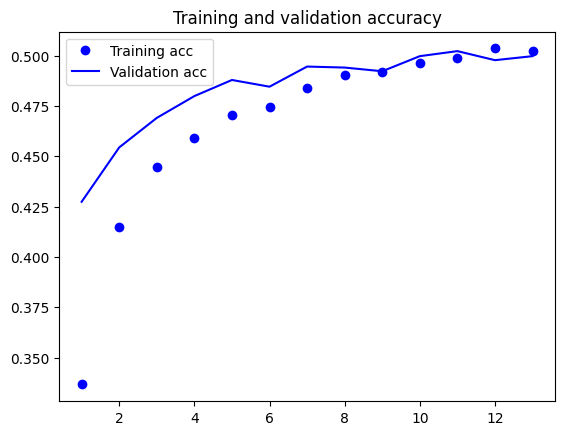

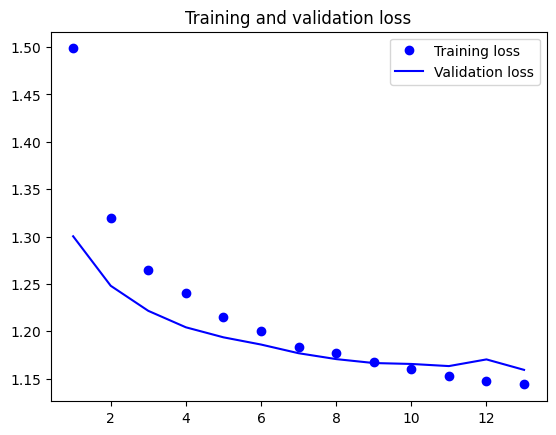

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Training and validation accuracy and loss began to plateau, indicating that the model had reached its maximum learning capacity without overfitting.
# Hence I selected this model as my final model for GRU

In [ ]:
# Save the Model
model.save('/content/drive/MyDrive/Deep Learning/GRU_model.keras')

### Final GRU Model

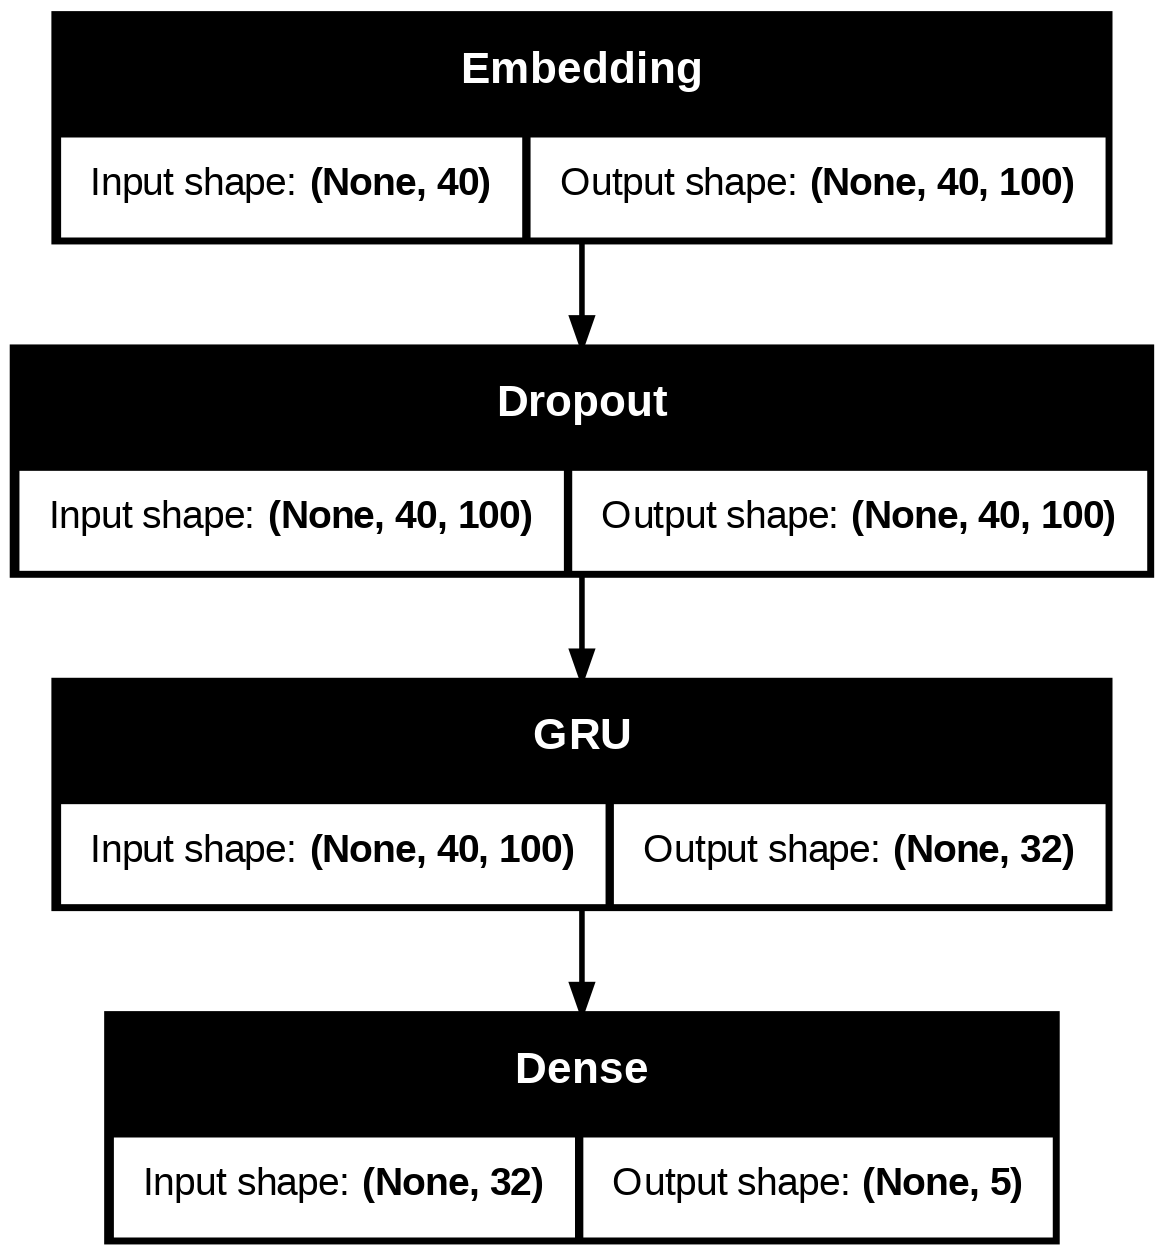

In [ ]:
# Load model
GRU_model = keras.models.load_model('/content/drive/My Drive/Deep Learning/GRU_model.keras')
from tensorflow.keras.utils import plot_model
plot_model(GRU_model, show_shapes = True, to_file='GRU_model.png')

## Step 3 – Evaluate the Model using Testing Data (Individual & Group)

In [7]:
# Load both Models
gru_model = load_model('/content/drive/MyDrive/Deep Learning/GRU_model.keras')
lstm_model = load_model('/content/drive/MyDrive/Deep Learning/LSTM_model.keras')

235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - acc: 0.4977 - loss: 1.1489
GRU Model - Test Accuracy: 0.4903, Test Loss: 1.1594
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step


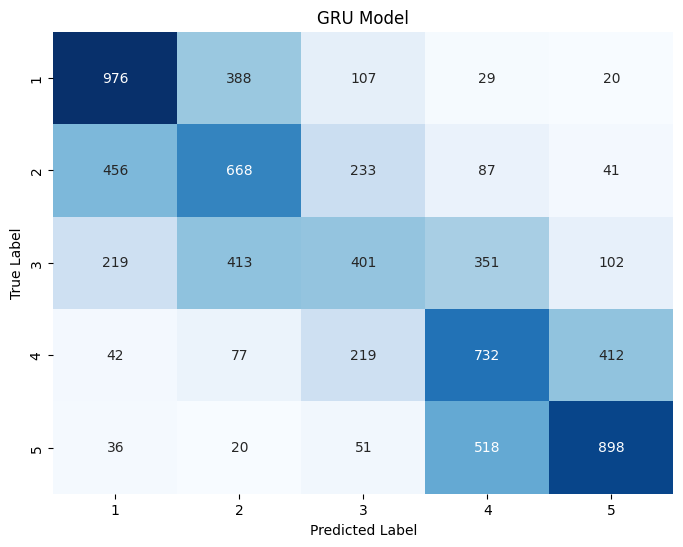

235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - acc: 0.4939 - loss: 1.1508
LSTM Model - Test Accuracy: 0.4897, Test Loss: 1.1622
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step


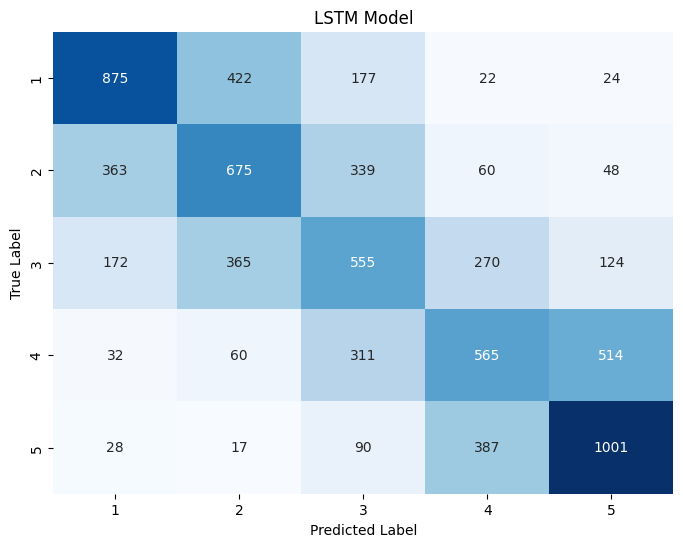

In [8]:
# Evaluate and display results
def evaluate_model(model, X_test, y_test, model_name='Model'):
    # Evaluate test accuracy and loss
    loss, acc = model.evaluate(X_test, y_test)
    print(f"{model_name} - Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

    # Predict probabilities and convert to class labels
    y_pred = model.predict(X_test)  # Get class probabilities
    y_pred_classes = np.argmax(y_pred, axis=1) # converts from one-hot vectors to class labels
    y_true_classes = np.argmax(y_test, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot Confusion Matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[1, 2, 3, 4, 5],
                yticklabels=[1, 2, 3, 4, 5])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(model_name)
    plt.show()

# Run evaluation for both models
evaluate_model(gru_model, X_test, y_test, model_name='GRU Model')
evaluate_model(lstm_model, X_test, y_test, model_name='LSTM Model')

In [ ]:
# The GRU Model has slightly higher test accuracy and slight lower loss but the difference is pretty negligible.
# As seen from the confusion matrix, both models correctly predict the majority of classes. However, the GRU model struggles with label 3, frequently misclassifying it as label 2.
# Whereas the LSTM model manages to predict the majority of reviews labelled 3 correctly.
# It is better to have a model that performs consistently across all classes hence LSTM model is chosen as the best and final model

In [ ]:
# Save the Best Model
lstm_model.save('/content/drive/MyDrive/Deep Learning/text_model_best.keras')